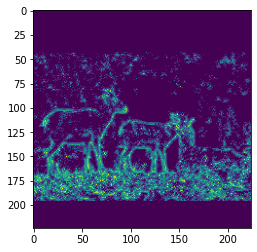

KeyboardInterrupt: 

In [15]:
import numpy as np
import torch
import linecache
import torch.utils.data as data

class ESImagenet_Dataset(data.Dataset):
    def __init__(self, mode, data_set_path='/data/ES-imagenet-0.18/'):
        super().__init__()
        self.mode = mode
        self.filenames = []
        self.trainpath = data_set_path+'train'
        self.testpath = data_set_path+'val'
        self.traininfotxt = data_set_path+'trainlabel.txt'
        self.testinfotxt = data_set_path+'vallabel.txt'
        self.formats = '.npz'
        if mode == 'train':
            self.path = self.trainpath
            trainfile = open(self.traininfotxt, 'r')
            for line in trainfile:
                filename, classnum, a, b = line.split()
                realname,sub = filename.split('.')
                self.filenames.append(realname+self.formats)
        else:
            self.path = self.testpath
            testfile = open(self.testinfotxt, 'r')
            for line in testfile:
                filename, classnum, a, b = line.split()
                realname,sub = filename.split('.')
                self.filenames.append(realname+self.formats)

    def __getitem__(self, index):
        if self.mode == 'train':
            info = linecache.getline(self.traininfotxt, index+1)
        else:
            info = linecache.getline(self.testinfotxt, index+1)
        filename, classnum, a, b = info.split()
        realname,sub = filename.split('.')
        filename = realname+self.formats
        filename = self.path + r'/' + filename
        classnum = int(classnum)
        a = int(a)
        b = int(b)
        datapos = np.load(filename)['pos'].astype(np.float64)
        dataneg = np.load(filename)['neg'].astype(np.float64)

        tracex = [0,2,1,0,2,1,1,2]
        tracey = [2,1,0,1,2,0,1,1]

        dy = (254 - b) // 2
        dx = (254 - a) // 2
        input = torch.zeros([ 2, 8,256, 256])
        

        x = datapos[:,0]+ dx
        y = datapos[:,1]+ dy
        t = datapos[:,2]-1
        input[0,t ,x ,y ] += 1
        
        x = dataneg[:,0]+ dx
        y = dataneg[:,1]+ dy
        t = dataneg[:,2]-1
        input[1,t,x ,y ] -= 1
        
        
        sum_gary_data = torch.zeros([1, 256, 256])
        reshape = input[:,:,16:240,16:240]
        H=224
        W=224
        for t in range(8):
            dx = tracex[t]
            dy = tracey[t]
            sum_gary_data[0,2-dx:2-dx+H,2-dy:2-dy+W] += reshape[0,t,:,:] 
            sum_gary_data[0,2-dx:2-dx+H,2-dy:2-dy+W] -= reshape[1,t,:,:]
            
        sum_gary_data = sum_gary_data[:,1:225,1:225]
        label = torch.tensor([classnum])
        return sum_gary_data, label

    def __len__(self):
        return len(self.filenames)
    
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,1)

test_dataset = ESImagenet_Dataset(mode='train')
for data,label in test_dataset:
    axes.imshow(data.permute(1,2,0))
    plt.show()